In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
from torch.nn import init
import pandas as pd
%matplotlib inline

In [2]:
from functorch import vmap, vjp
from functorch import jacrev, jacfwd

class NNApproximator(nn.Module):
  def __init__(self, dim_input = 1, dim_output = 2, num_hidden = 2, dim_hidden = 1, activation=nn.Tanh()):
    super().__init__()

    self.layer_in = nn.Linear(dim_input, dim_hidden)
    self.layer_out = nn.Linear(dim_hidden, dim_output)
    # self.A = nn.Parameter(torch.randn(2,2))
    self.k = nn.Parameter(torch.rand(1, requires_grad=True))
    # self.A = self.k * torch.from_numpy(np.array([[-1,1],[1,-1]]))

    num_middle = num_hidden - 1
    self.middle_layers = nn.ModuleList(
        [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
    )
    self.activation = activation

  def forward(self, x):
    out = self.activation(self.layer_in(x))
    for layer in self.middle_layers:
      out = self.activation(layer(out))
    return self.layer_out(out)

  # reference for implementing derivatives for batched inputs
  # https://pytorch.org/functorch/stable/notebooks/jacobians_hessians.html
  def jacobian(self, x):
    jac = vmap(jacrev(self.forward))
    return jac(x).squeeze()

In [3]:
def compute_data_loss(model, x_tr, y_tr):
  return 0.5 * torch.mean(((model.forward(x_tr) - y_tr) ** 2))

def compute_PINN_loss(model, x, k):
    F_dot = model.jacobian(x)
    s1 = x[:, 0:2] - x[:, 2:4]
    s2 = x[:, 4:6] - x[:, 2:4]

    s1 = s1 / torch.norm(s1, dim=1)[:, None]
    s2 = s2 / torch.norm(s2, dim=1)[:, None]

    s1rot = s1 @ torch.from_numpy(np.array([[0, -1], [1, 0]]).T).float()
    s2rot = s2 @ torch.from_numpy(np.array([[0, -1], [1, 0]]).T).float()

    f1_ax = torch.einsum('ij, ijk, ik->i', s1, F_dot[:, :, 0:2], s1) - k
    f2_ax = torch.einsum('ij, ijk, ik->i', s2, F_dot[:, :, 4:6], s2) - k
    f1_perp = torch.einsum('ij, ijk, ik->i', s1, F_dot[:, :, 0:2], s1rot)
    f2_perp = torch.einsum('ij, ijk, ik->i', s2, F_dot[:, :, 4:6], s2rot)

    loss = (f1_ax ** 2).mean() + (f2_ax ** 2).mean()
    loss += (f1_perp ** 2).mean() + (f2_perp ** 2).mean()

    return loss

In [4]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data, 5.0/3.0)

In [10]:
N_m = 3
in_dim = 6
out_dim = 2
num_layer = 3
hidden_dim = 32
xy_index = [[1, 2, 3, 4, 9, 10], [3, 4, 9, 10, 15, 16], [9, 10, 15, 16, 21, 22]]
F_index = [[7, 8], [13, 14], [19, 20]]
movable_index = [3, 4, 9, 10, 15, 16]
epoch = 50000
lr = 1e-3
noise_scale = 0

data_file = '../data/k=50_L=7_N=5_M=1.csv'

x = torch.from_numpy(np.asarray(pd.read_csv(data_file))).float()
noise = torch.randn(x.shape[0], N_m * 2) * torch.std(x[:, movable_index], dim=0) * noise_scale
x[:, movable_index] = noise + x[:, movable_index]
x_train = x[:, xy_index]
x_PINN = x_train.clone().requires_grad_(True)
F = x[:, F_index]

In [6]:
def train_model(model, data_loss_fn, PINN_loss_fn, learning_rate=0.0001, max_epochs=1000):
  tr_losses = []

  # reference on torch.LBFGS usage
  # https://gist.github.com/tuelwer/0b52817e9b6251d940fd8e2921ec5e20
  USE_BFGS = False

  if USE_BFGS:
    optimizer = torch.optim.LBFGS(model.parameters())
    print("Using BFGS optimizer ... ")
    log_iter = 1000
    def closure():
        optimizer.zero_grad()
        objective = data_loss_fn(model) + PINN_loss_fn(model)
        objective.backward()
        return objective
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-3)
    print("Using Adam optimizer ... ")
    log_iter = 5000
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 40000, 0.1, verbose=False)

  weight = 1e1
  for epoch in range(max_epochs):
    loss = 0
    total_loss = 0

    for i in range(0, N_m):
      loss += data_loss_fn(model, i) + PINN_loss_fn(model, i, weight)
      total_loss += compute_data_loss(model, x_train[:, i], F[:, i]).detach()

    loss /= N_m
    total_loss /= N_m

    if USE_BFGS:
      optimizer.step(closure)
    else:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # lr_scheduler.step()

      # if epoch == 25000:
      #   weight = 5e1
      #   print(f'weight of PINN loss increased to {weight}')

    if epoch % log_iter == 0:
      print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")
      print(f"Loss over entire dataset: {float(total_loss):>7f}")
    tr_losses.append(total_loss.detach().numpy())

  return model, np.array(tr_losses)

Using Adam optimizer ... 
Epoch: 0 - Loss: 50113.316406
Loss over entire dataset: 11.150525
Epoch: 5000 - Loss: 1.056998
Loss over entire dataset: 0.254928
Epoch: 10000 - Loss: 0.520714
Loss over entire dataset: 0.127235
Epoch: 15000 - Loss: 0.203019
Loss over entire dataset: 0.066506
Epoch: 20000 - Loss: 0.334492
Loss over entire dataset: 0.116803
Epoch: 25000 - Loss: 0.192938
Loss over entire dataset: 0.046959
Epoch: 30000 - Loss: 3.460373
Loss over entire dataset: 1.118602
Epoch: 35000 - Loss: 0.127479
Loss over entire dataset: 0.038735
Epoch: 40000 - Loss: 0.074464
Loss over entire dataset: 0.033210
Epoch: 45000 - Loss: 0.105299
Loss over entire dataset: 0.039751


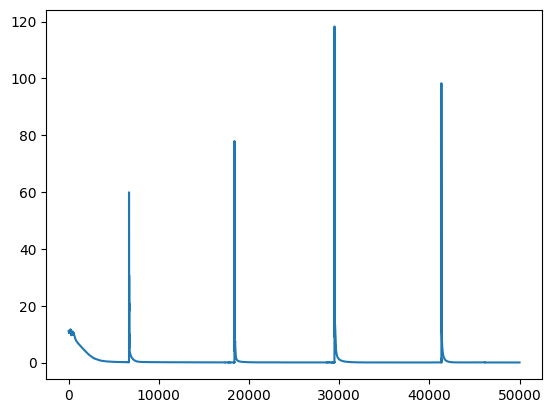

In [12]:
model = NNApproximator(dim_input=in_dim, dim_output=out_dim, num_hidden=num_layer, dim_hidden=hidden_dim)
model.apply(initialize_weights)
model, tr_losses = train_model(
    model,
    data_loss_fn=lambda model, mass_idx: compute_data_loss(model, x_train[:500, mass_idx], F[:500, mass_idx]),
    PINN_loss_fn=lambda model, mass_idx, weight: weight*compute_PINN_loss(model, x_PINN[:, mass_idx], 50),
    learning_rate=lr,
    max_epochs=epoch,
)
plt.plot(tr_losses)

In [13]:
def getqdot(x, xdot, model, xLeft, xRight):
    N_m = x.shape[0] // 2

    x = np.concatenate((xLeft, x, xRight))
    forces = []
    for i in range(0, N_m):
        triplet = x[np.arange(2*i, 2*i + 6)]
        force = model.forward(torch.from_numpy(triplet).float())
        forces.append(force.detach().numpy())
        # force = getSpringForcesOnMass(triplet[:2],triplet[2:4],triplet[4:])
        # forces.append(force)

    forces = np.concatenate(forces).reshape(-1)

    q0 = np.concatenate((x, xdot))
    qdot = np.concatenate((xdot, forces))
    return qdot

def compute_trajectory(x0, x0dot, model, xLeft, xRight):
    N_m = x0.shape[0] // 2
    q0 = np.concatenate((x0, x0dot))

    t0 = 0
    tf = 20
    Nt = 101
    sol = solve_ivp(lambda t, q: getqdot(q[:2*N_m], q[2*N_m:], model, xLeft, xRight), [t0,tf], y0=q0, t_eval=np.linspace(t0, tf, Nt))
    y = sol.y
    t = sol.t
    return y, t

# modify as appropriate:
N_m = 3
xLeft = x[0, 1:3]
xRight = x[0, 21:23]

# # the vector 'x0' contains the initial positions of the *movable* masses
# # i.e. x0.shape = [N_m * 2]
x0 = x[0, movable_index]
# x0 = np.c_[x0, np.zeros_like(x0)].reshape(-1)
# print(x0)
x0dot = np.zeros_like(x0)

y, t = compute_trajectory(x0,x0dot,model,xLeft,xRight)

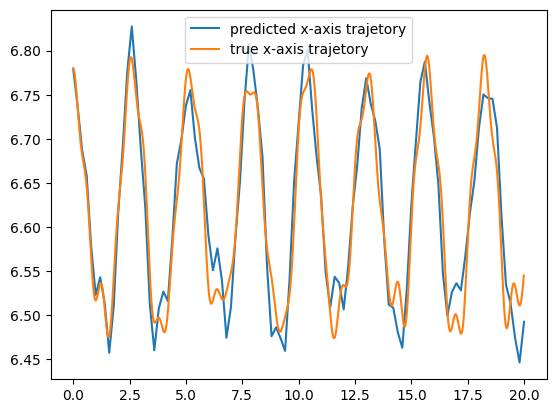

In [17]:
plt.plot(t, y.T[:, 0], label='predicted x-axis trajetory')
plt.plot(x[:, 0], x[:, 3], label='true x-axis trajetory')
plt.legend()

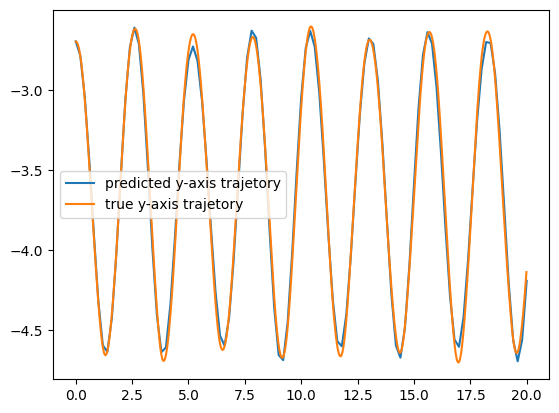

In [18]:
plt.plot(t, y.T[:, 1], label='predicted y-axis trajetory')
plt.plot(x[:, 0], x[:, 4], label='true y-axis trajetory')
plt.legend()

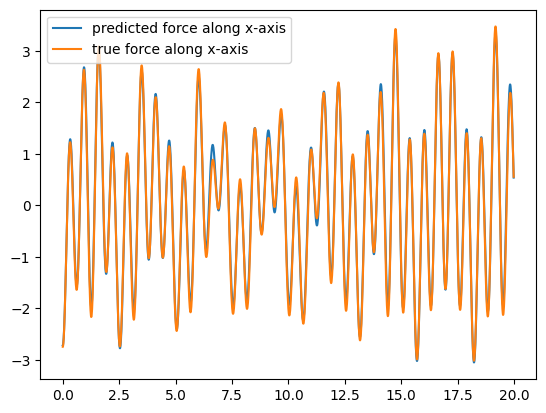

In [15]:
plt.plot(x[:, 0], model.forward(x_train[:, 0])[:, 0].detach().numpy(), label='predicted force along x-axis')
plt.plot(x[:, 0], F[:, 0][:, 0], label='true force along x-axis')
plt.legend()

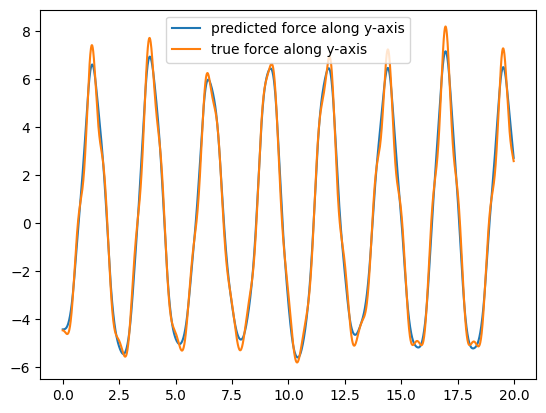

In [16]:
plt.plot(x[:, 0],  model.forward(x_train[:, 0])[:, 1].detach().numpy(), label='predicted force along y-axis')
plt.plot(x[:, 0], F[:, 0][:, 1], label='true force along y-axis')
plt.legend()